In [1]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from Bio import SeqIO, SeqUtils
from Bio.SeqUtils.IsoelectricPoint import IsoelectricPoint
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [188]:
generated = list(SeqIO.parse("/Users/mzvyagin/Documents/reverse_protein_design/likely-wood-857_1024concat_seqs_reconstructed.fasta", "fasta"))

In [189]:
generated_seqs = [s.seq for s in generated]

In [190]:
generated_protein_seqs = [s.translate(to_stop=True) for s in generated_seqs]

In [5]:
def gc_content(seqs):
    return [SeqUtils.GC(rec) for rec in seqs]

def seq_length(seqs):
    return [len(rec) for rec in seqs]

def molecular_weight(seqs):
    return [SeqUtils.molecular_weight(rec, "protein") for rec in seqs]

def isoelectric_point(seqs):
    return [IsoelectricPoint(seq).pi() for seq in seqs]

In [6]:
generated_paint_df = pd.DataFrame({
        "GC": gc_content(generated_seqs),
        "SequenceLength": seq_length(generated_seqs),
        "MolecularWeight": molecular_weight(generated_protein_seqs),
        "IsoelectricPoint": isoelectric_point(generated_protein_seqs),
})

In [7]:
generated_embeddings = np.load("/Users/mzvyagin/Documents/reverse_protein_design/likely-wood-857-1024concat_seqs_fasta_embeddings_mean.npy")

In [8]:
len(generated_embeddings)

1024

In [9]:
tsne = TSNE().fit_transform(generated_embeddings)

/Users/mzvyagin/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/mzvyagin/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [10]:
def plot_tsne(data_proj: np.ndarray, paint: np.ndarray, paint_name: str, cmap: str = "viridis"):
    df = pd.DataFrame({"z0": data_proj[:, 0], "z1": data_proj[:, 1], paint_name: paint[:data_proj.shape[0]]})
    ax2 = df.plot.scatter(x='z0', y='z1',c=paint_name, colormap=cmap, alpha=0.4)
    plt.show()
    return df

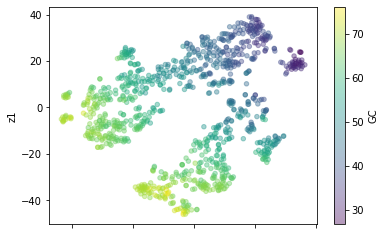

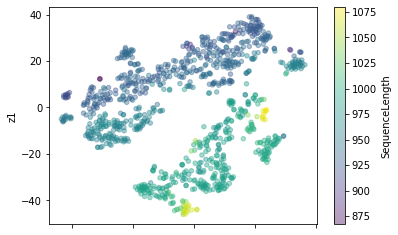

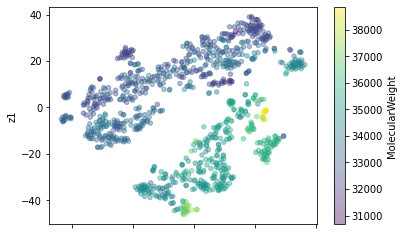

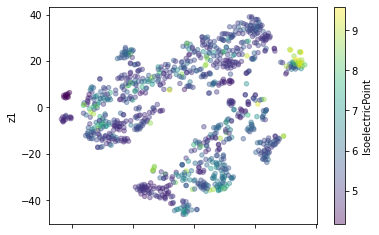

In [11]:
for key in generated_paint_df:
    gen_df = plot_tsne(tsne, generated_paint_df[key], key, cmap="viridis")

In [277]:
kmeans = KMeans(n_clusters=12, random_state=0).fit(generated_embeddings)

In [278]:
kmeans

KMeans(n_clusters=12, random_state=0)

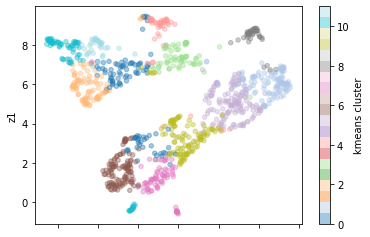

In [285]:
gen_df = plot_tsne(umap_output, kmeans.labels_, "kmeans cluster", cmap="tab20")

In [ ]:
kmeans.inertia_

In [ ]:
inertia = []
for x in tqdm(range(1, 15)):
    kmeans = KMeans(n_clusters=x, random_state=0).fit(generated_embeddings)
    inertia.append(kmeans.inertia_)

In [ ]:
plt.plot(inertia)
plt.title("inertia for k means")

In [ ]:
import sklearn

In [ ]:
sklearn.__version__

In [288]:
from sklearn.mixture import GaussianMixture

In [294]:
gmm = GaussianMixture(12, 
                     covariance_type='full', init_params="kmeans",
                     random_state=100).fit(generated_embeddings)

In [295]:
gmm.bic(generated_embeddings)

15423379.242903475

In [296]:
labels = gmm.predict(generated_embeddings)

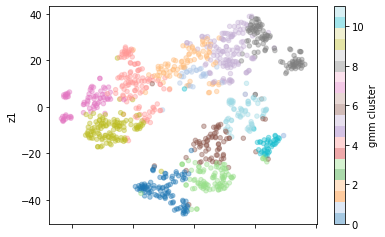

In [298]:
gen_df = plot_tsne(tsne, labels, "gmm cluster", cmap="tab20")

In [299]:
aic, bic = [], []
for i in tqdm(range(1, 15)):
    gmm = GaussianMixture(i, 
                     covariance_type='full', init_params="kmeans",
                     random_state=100).fit(generated_embeddings)
    aic.append(gmm.aic(generated_embeddings))
    bic.append(gmm.bic(generated_embeddings))

100%|██████████| 14/14 [00:25<00:00,  1.80s/it]


Text(0.5, 1.0, 'gmm full covariance')

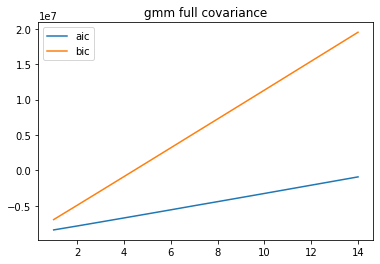

In [300]:
plt.plot(range(1, 15), aic, label="aic")
plt.plot(range(1, 15), bic, label="bic")
plt.legend()
plt.title("gmm full covariance")

In [31]:
from sklearn.cluster import SpectralClustering, AffinityPropagation, DBSCAN, OPTICS

In [32]:
sc = SpectralClustering()

In [33]:
sc_labels = sc.fit_predict(generated_embeddings)

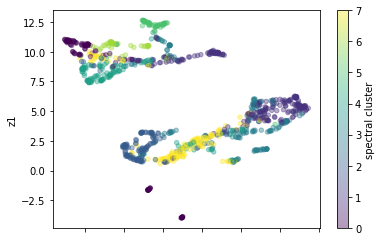

In [34]:
gen_df = plot_tsne(umap_output, sc_labels, "spectral cluster", cmap="viridis")

In [35]:
af = AffinityPropagation()

In [36]:
af_labels = af.fit_predict(generated_embeddings)

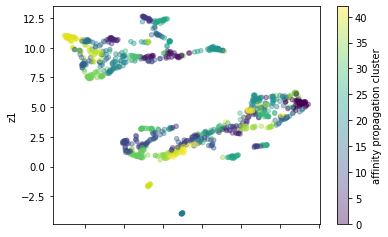

In [37]:
gen_df = plot_tsne(umap_output, af_labels, "affinity propagation cluster", cmap="viridis")

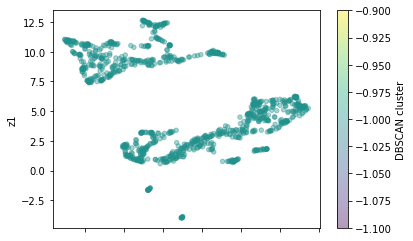

In [47]:
db = OPTICS(cluster_method="dbscan", metric="hamming")
db_labels = db.fit_predict(generated_embeddings)
gen_df = plot_tsne(umap_output, db_labels, "DBSCAN cluster", cmap="viridis")

In [113]:
from sklearn.cluster import FeatureAgglomeration

In [114]:
spectral_embedding = FeatureAgglomeration().fit_transform(generated_embeddings)

In [115]:
spectral_embedding.shape

(1024, 2)

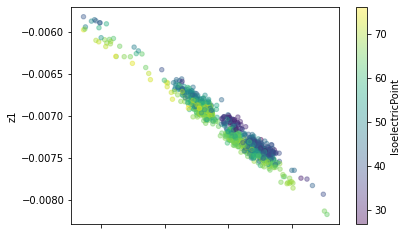

In [116]:
gen_df = plot_tsne(spectral_embedding, generated_paint_df['GC'], key, cmap="viridis")

In [117]:
from umap import UMAP

In [118]:
umap_output = UMAP(n_neighbors=30, min_dist=0.2, random_state=42).fit_transform(generated_embeddings)

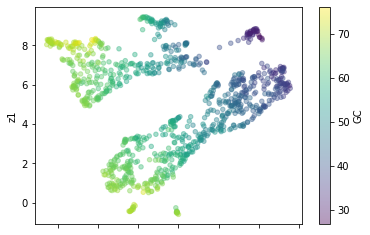

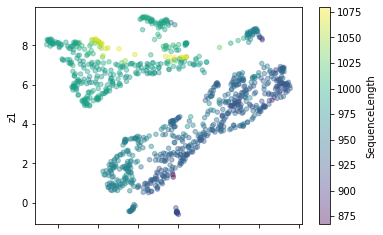

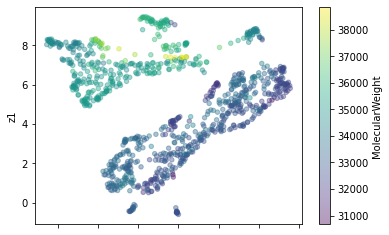

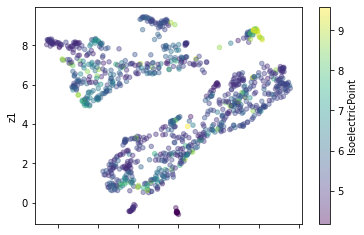

In [119]:
for key in generated_paint_df:
    gen_df = plot_tsne(umap_output, generated_paint_df[key], key, cmap="viridis")

In [18]:
import hdbscan

In [153]:
labels = hdbscan.HDBSCAN(
    # min_samples=100,
    min_cluster_size=10,
    # metric="dice"
).fit_predict(generated_embeddings)

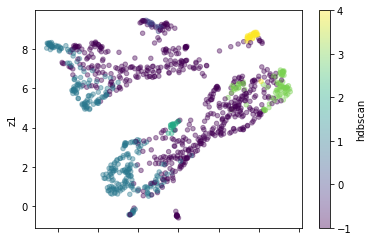

In [272]:
gen_df = plot_tsne(umap_output, labels, "hdbscan", cmap="viridis")

In [155]:
from collections import Counter

In [159]:
Counter(labels).keys()

dict_keys([3, -1, 1, 4, 2, 0])

In [157]:
from math import ceil, floor
import random
random.seed(0)

In [ ]:
(labels == -1).nonzero()[0]

In [176]:
#sample from the clusters based on the cluster size
# 96 * (cluster_size / N_seqs)
sampled_sequences = {}
for i in range(-1, 5):
    # get the indices that are part of that cluster
    indices = list((labels == i).nonzero()[0])
    cluster_size = len(indices)
    num_sequences_to_sample = round(96 * (cluster_size/1024))
    sample = random.sample(indices, num_sequences_to_sample)
    sampled_sequences[i] = sample

In [177]:
sampled_sequences

{-1: [583,
  594,
  645,
  155,
  595,
  62,
  72,
  476,
  273,
  250,
  511,
  629,
  689,
  980,
  219,
  517,
  189,
  847,
  415,
  84,
  540,
  308,
  934,
  118,
  532,
  703,
  575,
  527,
  732,
  179,
  165,
  1004,
  852,
  840,
  600,
  211,
  848,
  191,
  890,
  759,
  64,
  589,
  260,
  285,
  1011,
  658,
  147,
  110,
  143,
  340,
  381,
  103,
  670,
  23,
  163],
 0: [513, 327],
 1: [940,
  578,
  825,
  881,
  439,
  782,
  180,
  711,
  442,
  510,
  353,
  792,
  401,
  691,
  228,
  139,
  49,
  949,
  846,
  419,
  246,
  905,
  744,
  498,
  433,
  79,
  438],
 2: [276, 270],
 3: [306, 720, 592, 542, 841, 242, 149, 791],
 4: [157, 573, 445]}

In [178]:
import pickle
with open("cluster_sequence_samples.pkl", "wb") as f:
    f.write(pickle.dumps(sampled_sequences))

In [179]:
sampled_indices = []
[sampled_indices.extend(s) for s in sampled_sequences.values()]

[None, None, None, None, None, None]

In [260]:
print(sampled_indices)

[583, 594, 645, 155, 595, 62, 72, 476, 273, 250, 511, 629, 689, 980, 219, 517, 189, 847, 415, 84, 540, 308, 934, 118, 532, 703, 575, 527, 732, 179, 165, 1004, 852, 840, 600, 211, 848, 191, 890, 759, 64, 589, 260, 285, 1011, 658, 147, 110, 143, 340, 381, 103, 670, 23, 163, 513, 327, 940, 578, 825, 881, 439, 782, 180, 711, 442, 510, 353, 792, 401, 691, 228, 139, 49, 949, 846, 419, 246, 905, 744, 498, 433, 79, 438, 276, 270, 306, 720, 592, 542, 841, 242, 149, 791, 157, 573, 445]


In [261]:
len(sampled_indices)

97

In [181]:
len(set(sampled_indices))

97

In [182]:
indices_labels = np.zeros(1024)

In [183]:
indices_labels[sampled_indices] = 1

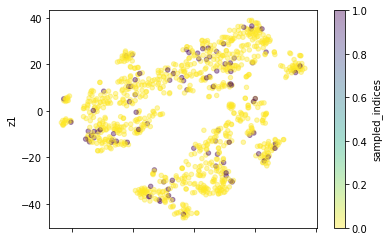

In [191]:
gen_df = plot_tsne(tsne, indices_labels, "sampled_indices", cmap="viridis_r")

In [192]:
generated[0].id

'MDHSyntheticSequence-LikelyWood857_0'

In [193]:
for n, i in enumerate(generated):
    i.name += "_index{}".format(n)
    i.id += "_index{}".format(n)
    i.description += "_index{}".format(n)

In [194]:
generated_protein_records = []
for s in generated:
    protein_record = s.translate(to_stop=True)
    protein_record.name = s.name + "_translated"
    protein_record.description = s.description + "_translated"
    protein_record.id = s.id + "_translated"
    generated_protein_records.append(protein_record)

In [195]:
generated_protein_records[0].seq

Seq('MKVTVVGAGAVGASCAEYIAIKDFASEVVLLDIKEGYAEGKAMDLMQTASLNGF...LEL')

In [196]:
sampled_protein_records = []
for x in sampled_indices:
    sampled_protein_records.append(generated_protein_records[x])

In [197]:
len(sampled_protein_records)

97

In [198]:
sampled_gene_records = []
for x in sampled_indices:
    sampled_gene_records.append(generated[x])

In [199]:
import os
os.getcwd()

'/Users/mzvyagin/Documents/gene_transformer/examples/perlmutter/notebook'

In [205]:
SeqIO.write(sampled_gene_records, "likely-wood-857-sampled_from_clusters_95_seqs.fasta", "fasta")

97

In [201]:
sampled_protein_records[0].name

'MDHSyntheticSequence-LikelyWood857_345_index583_translated'

In [202]:
names = [s.name for s in sampled_protein_records]

In [203]:
len(names)

97

In [204]:
len(set(names))

97

In [207]:
for s in sampled_protein_records:
    SeqIO.write(s, "likely-wood-857-sampled_from_clusters_97_seqs_translated/{}.fasta".format(s.name), "fasta")

In [208]:
# paint by selected indices based on alignment

In [210]:
highest_mean_string = """864 596 986 749  27  31 646 235  77 640  28 926 411 795 850 991 329 637
 681 567 739 985 202 266 208 467 148 726 470 971  75 690   3 721   7  36
 657  90 514 566  47 790 117 255 610 171 380 471 636 224 186 983 963 239
 490 553  14 953 424 603 720 860 101 265 861  33 582  87 330 747 504 217
  92 919 536 299 430 964 412 655  98 284 802  12 679 803 246 641 399 459
 232 448 328 131 768 541"""

In [213]:
highest_mean_alignments = highest_mean_string.split()

In [215]:
highest_mean_alignments = [int(x) for x in highest_mean_alignments]

In [232]:
highest_mean_alignment_scores = [163.13949671772428, 163.17724288840262, 163.20760393873084, 163.21389496717725, 163.27242888402625, 163.27407002188184, 163.32740700218818, 163.3323304157549, 163.37746170678338, 163.37828227571117, 163.38156455142231, 163.42915754923413, 163.45705689277898, 163.48057986870896, 163.4879649890591, 163.48823851203502, 163.49398249452955, 163.50875273522976, 163.51586433260394, 163.5172319474836, 163.52051422319474, 163.53172866520788, 163.53610503282275, 163.58561269146608, 163.66274617067833, 163.67778993435448, 163.69119256017507, 163.73741794310723, 163.74042669584244, 163.76996717724288, 163.80278993435448, 163.80333698030634, 163.81892778993435, 163.87390590809628, 163.89742888402625, 163.92259299781182, 163.95924507658643, 163.96115973741794, 164.01969365426694, 164.02516411378556, 164.03884026258206, 164.09846827133478, 164.1047592997812, 164.13566739606128, 164.1512582056893, 164.18681619256017, 164.20131291028446, 164.21772428884026, 164.2409737417943, 164.25492341356673, 164.28528446389495, 164.30032822757113, 164.3405361050328, 164.3503829321663, 164.3823851203501, 164.41739606126916, 164.42177242888403, 164.44638949671773, 164.48057986870896, 164.49316192560175, 164.54349015317285, 164.57713347921225, 164.58342450765863, 164.61433260393872, 164.64907002188184, 164.67396061269147, 164.6832603938731, 164.70103938730853, 164.72592997811816, 164.7335886214442, 164.74425601750548, 164.77653172866522, 164.77762582056891, 164.79814004376368, 164.8323304157549, 164.83506564551422, 164.88265864332604, 164.91001094091905, 164.93107221006565, 165.02407002188184, 165.0667396061269, 165.07084245076587, 165.10421225382933, 165.1805251641138, 165.25246170678338, 165.34190371991247, 165.38676148796498, 165.54704595185996, 165.55087527352296, 165.5675601750547, 165.70951859956236, 165.75328227571117, 166.02653172866522, 166.04130196936543, 166.44474835886214, 166.56099562363238]

In [217]:
len(highest_mean_alignments)

96

In [233]:
highest_mean_alignment_paints = np.zeros(1024)
highest_mean_alignment_paints[highest_mean_alignments] = highest_mean_alignment_scores

In [255]:
def _plot_tsne(data_proj: np.ndarray, paint: np.ndarray, paint_name: str, cmap: str = "viridis", cmap_min=0):
    df = pd.DataFrame({"z0": data_proj[:, 0], "z1": data_proj[:, 1], paint_name: paint[:data_proj.shape[0]]})
    ax2 = df.plot.scatter(x='z0', y='z1',c=paint_name, colormap=cmap, alpha=0.4, vmin=cmap_min)
    plt.show()
    return df

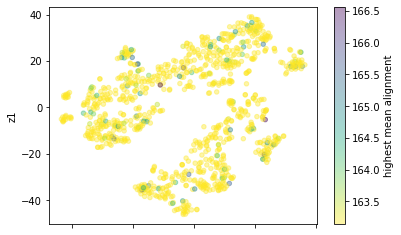

In [263]:
gen_df = _plot_tsne(tsne, highest_mean_alignment_paints, "highest mean alignment", cmap="viridis_r", cmap_min=min(highest_mean_alignment_scores))

In [223]:
highest_max_string = """586  757  488  329  749  326  388  371   68  750 1005  851  401  825
  892  523  994  235  910  869  481   37  197    6  558  413  512  313
  480   64   81  320  726  862   74  839  145  600  612 1011  783  774
  923  509  338  153  562   31   28  821  712   21  999 1007  307  716
  290 1020  800  174  744  758  845  179   13  224  670  696  941  437
  135  226  539  674   11  442  422  859   71  618  901  461  546  464
  828  482  229  705  396  341 1009  935  943  653  392  175
"""

In [226]:
highest_max_alignments = highest_max_string.split()
highest_max_alignments = [int(x) for x in highest_max_alignments]
len(highest_max_alignments)

96

In [252]:
highest_max_alignment_paints = np.zeros(1024)
highest_max_alignment_paints[highest_max_alignments] = highest_max_alignment_scores

In [253]:
highest_max_alignment_scores = [312.0, 312.0, 312.0, 312.0, 312.0, 312.0, 313.0, 313.0, 313.0, 313.0, 313.0, 313.0, 313.0, 313.0, 313.0, 313.0, 313.0, 313.0, 313.0, 314.0, 314.0, 314.0, 314.0, 314.0, 314.0, 314.0, 314.0, 314.0, 314.0, 314.0, 314.0, 314.0, 314.0, 315.0, 315.0, 315.0, 315.0, 315.0, 315.0, 315.0, 315.0, 316.0, 316.0, 316.0, 316.0, 316.0, 316.0, 316.0, 316.0, 316.0, 316.0, 317.0, 317.0, 317.0, 317.0, 317.0, 317.0, 317.0, 317.0, 318.0, 318.0, 318.0, 318.0, 318.0, 318.0, 319.0, 319.0, 319.0, 319.0, 319.0, 319.0, 320.0, 320.0, 320.0, 320.0, 321.0, 321.0, 321.0, 321.0, 321.0, 321.0, 321.0, 321.0, 321.0, 322.0, 322.0, 322.0, 322.0, 322.0, 322.0, 322.0, 322.0, 323.0, 323.0, 323.0, 327.0]

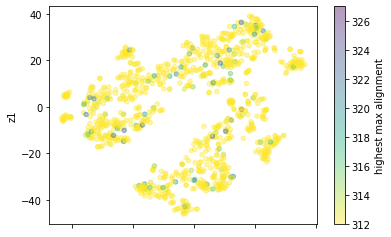

In [258]:
gen_df = _plot_tsne(tsne, highest_max_alignment_paints, "highest max alignment", cmap="viridis_r", cmap_min=min(highest_max_alignment_scores))

In [230]:
max_intersect = np.intersect1d(sampled_indices, highest_max_alignments)
len(max_intersect)

9

In [231]:
mean_intersect = np.intersect1d(sampled_indices, highest_mean_alignments)
len(mean_intersect)

2

### Combining Diverse Sampling with Bioinformatics Approach of Max/Mean Alignments

We're going to take the same density/cluster based sampling approach, but within each cluster, we're going to select the top X number of sequences based off the alignment score, as opposed to randomly selecting within the cluster. 